__**Table of Contents**__
====

>#### [5/8/2019 - 5//2019](#5082019)
&emsp;   Working on giant cut

<a id='5082019'></a>

5/8/2019 - 5//2019
====

>### The DESI people are looking for targets for "Science Verification," and they want giant targets from the DDO51 survey. I work on this below.

In [88]:
# Import modules
import numpy as np
from scipy import stats
import basic
from astropy.table import Table
import warnings

#Suppress iPython warnings
warnings.filterwarnings('ignore')

#Import list of exposures/CCDs
night = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\exposures.fits')

#Create blank array with 200*200 bins
retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0
retm4 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0

#Load bin edges
xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\xedgegigd200b.npy')
yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\yedgegigd200b.npy')

#Look at 100 exposures
for i in range(0,300):   ###LOADING ALL CCDS AT ONCE
    
    #Load data using basic.py
    t = basic.Catalog.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(
        night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]))
    
    #Loading subscriptable catalog
    z = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(
        night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]))    
    
    #Correct for extinction
    g_extinct = t.extinction_correct('g')
    i_extinct = t.extinction_correct('i')
    d_extinct = t.extinction_correct('ddo51')

    ##########################
    ########  CUTS  ##########
    ##########################
    
    #Cuts
    ind, = np.where((z['e_ddo51']<0.3)&                    # Require okay errors
    (z['m_gaia']==2))                                      # Require a Gaia DR2 match
    
    #Applying match cuts
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Magnitude of less than 20 cut
    ind, = np.where(g_extinct<20)
    
    #Applying magnitude cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Remove nans
    ind = np.where((~np.isnan(g_extinct))&(~np.isnan(i_extinct))&(~np.isnan(d_extinct)))
    
    #nan cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
        
    ##########################
    ##########################
      
    #Numpy arrays with photometry
    g = np.array(g_extinct)
    i = np.array(i_extinct)
    d = np.array(d_extinct)
    
    #Colors
    y = g - d
    x = g - i
    
    ret,xed,yed,bin = stats.binned_statistic_2d(x,y,None,'count',bins=[xedge,yedge])
        
    retm3 = np.add(ret,retm3)

    #Removing last entry.  This will enable me to recenter the array values on the center of the bins.
    xe = xedge[0:200]
    ye = yedge[0:200]

    #Centering x and y values on center of bins
    xc = xe + (xedge[1] - xedge[0])/2
    yc = ye + (yedge[1] - yedge[0])/2

    count = retm3.T

    #Build up y values from maximum counts in each column
    ymaxcount = np.array([],dtype=int)
    for i in range(0,200):
        ycol = count[:,i]
        ymaxcount = np.append(ymaxcount,np.max(ycol))

    yidx = np.array([],dtype=int)

    for i in range(0,200):
        ycol = count[:,i]
        yt = np.where(count[:,i]==ymaxcount[i])
        yt = np.round(np.average(yt))
        yidx = np.array(np.append(yidx,yt),dtype=int)

    xcoord = xc
    ycoord = yc[yidx]

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    dloc = smooth(ycoord,12)
    #dloc = ycoord

    ind = np.where((xcoord>0)&(xcoord<2.5))
    dloc = dloc[ind]
    xcoord = xcoord[ind]

    #Adjusted dwarf locus
    photint = np.interp(x,xcoord,dloc)
    y = y  - photint

    ret,xed,yed,bin = stats.binned_statistic_2d(x,y,None,'count',bins=[xedge,yedge])

    retm4 = np.add(ret,retm4)   

<IPython.core.display.Javascript object>


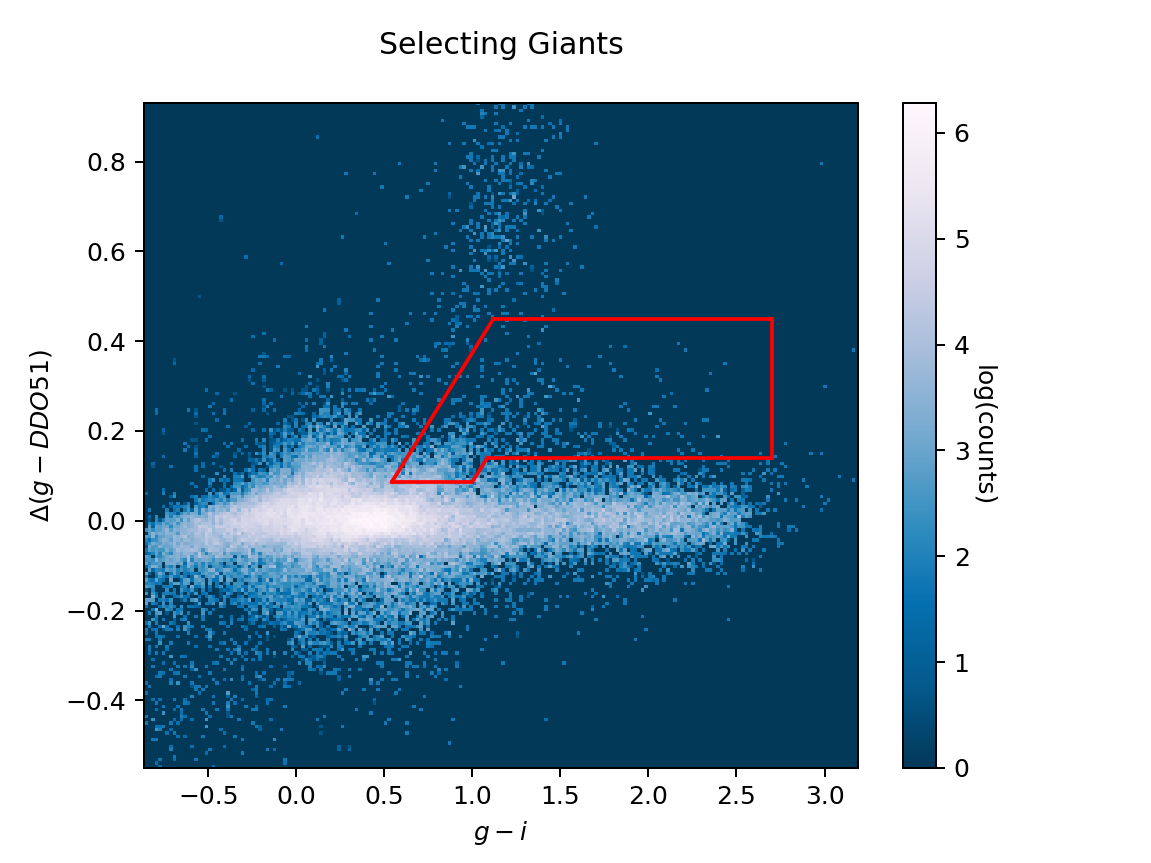

In [97]:
#Import modules
import matplotlib.pyplot as plt
%matplotlib nbagg

retm4[retm4==0]=1
ax = plt.imshow(np.log(retm4.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower',cmap='PuBu_r', aspect="auto")
plt.xlabel(r'$g-i$')
plt.ylabel(r'$\Delta (g-DDO51)$')
plt.title('Selecting Giants', y=1.05)
cbar = plt.colorbar()
cbar.set_label('log(counts)', rotation=270, labelpad=10)

#plt.scatter([0.62,1.13,1.20,1.71],[0.1,0.1,0.35,0.35],s=4,c='red')

plt.plot([0.544,1.12],[0.087,0.45],'k-',c='red')
plt.plot([0.544,1],[0.087,0.087],'k-',c='red')
plt.plot([1,1.0841],[0.087,0.14],'k-',c='red')
plt.plot([1.0841,2.7],[0.14,0.14],'k-',c='red')
plt.plot([1.12,2.7],[0.45,0.45],'k-',c='red')
plt.plot([2.7,2.7],[0.45,0.14],'k-',c='red')


plt.show()

<IPython.core.display.Javascript object>


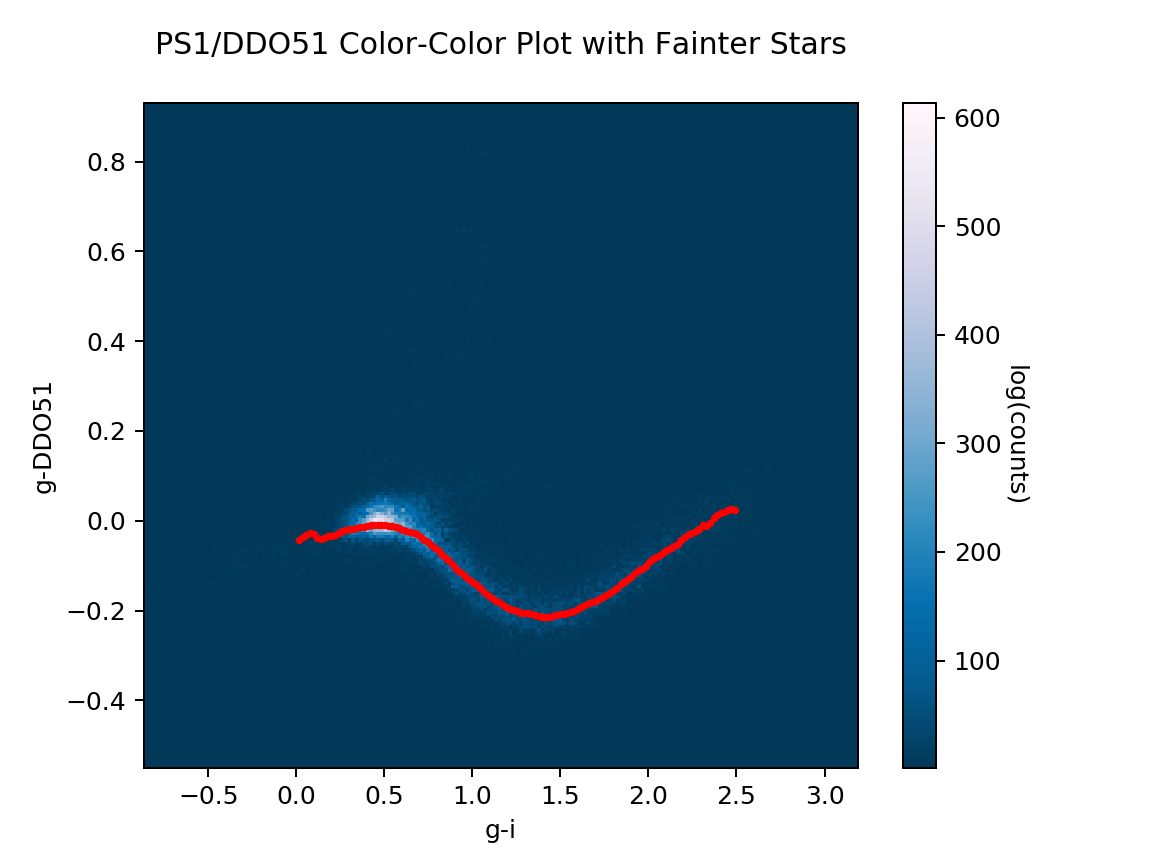

In [80]:
# Import modules
import numpy as np
from scipy import stats
import basic
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings
%matplotlib nbagg

#Suppress iPython warnings
warnings.filterwarnings('ignore')

#Import list of exposures/CCDs
night = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\exposures.fits')

#Create blank array with 200*200 bins
retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0
retm4 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0

#Load bin edges and counting
xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_xedge.npy')
yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_yedge.npy')
retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_counts_lt_m18d5.npy')
count = retm3.T

#Removing last entry.  This will enable me to recenter the array values on the center of the bins.
xe = xedge[0:200]
ye = yedge[0:200]

#Centering x and y values on center of bins
xc = xe + (xedge[1] - xedge[0])/2
yc = ye + (yedge[1] - yedge[0])/2

#Build up y values from maximum counts in each column
ymaxcount = np.array([],dtype=int)
for i in range(0,200):
    ycol = count[:,i]
    ymaxcount = np.append(ymaxcount,np.max(ycol))

yidx = np.array([],dtype=int)

for i in range(0,200):
    ycol = count[:,i]
    yt = np.where(count[:,i]==ymaxcount[i])
    yt = np.round(np.average(yt))
    yidx = np.array(np.append(yidx,yt),dtype=int)

xcoord = xc
ycoord = yc[yidx]

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#Y-Coordinates near high density region
#ind, = np.where((xcoord<0.598)&(xcoord>0))
#ycoord1 = ycoord[ind]
#xcoord1 = xcoord[ind]
#dloc1 = smooth(ycoord1,12)

#ind, = np.where((xcoord>0.598)&(xcoord<2.5))
#ycoord2 = ycoord[ind]
#xcoord2 = xcoord[ind]
#dloc2 = smooth(ycoord2,18)

#Join all coordinates
#xcoord = np.append(xcoord1,xcoord2)
#dloc = np.append(dloc1,dloc2)

#Derive dwarf locus
dloc = smooth(ycoord,12)

#Restrict dwarf locus
ind, = np.where((xcoord<2.5)&(xcoord>0))
dloc = dloc[ind]
xcoord = xcoord[ind]

#Plot of all stars in dataset 
retm3[retm3==0]=1
ax = plt.imshow((retm3.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower',cmap='PuBu_r', aspect="auto")
plt.xlabel('g-i')
plt.ylabel('g-DDO51')

plt.title('PS1/DDO51 Color-Color Plot with Fainter Stars', y=1.05)
cbar = plt.colorbar()
cbar.set_label('log(counts)', rotation=270, labelpad=10)

#Overplotting dwarf locus
plt.scatter(xcoord,dloc,s=4,c='red')

plt.show()

In [60]:
len(dloc)

123

In [139]:
# Import modules
import numpy as np
from scipy import stats
import basic
from astropy.table import Table
import warnings

#Suppress iPython warnings
warnings.filterwarnings('ignore')

#Import list of exposures/CCDs
night = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\exposures.fits')

#Create blank array with 200*200 bins
retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0
retm4 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0

#Load bin edges
xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\xedgegigd200b.npy')
yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\yedgegigd200b.npy')

#Load all exposures (43548)
for i in range(0,100):
    #Load data using basic.py
    chip = int(night['ccdn'][i])
    t = basic.Catalog.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), chips=chip)
    
    #Loading subscriptable catalog
    z = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), path="{0}".format(chip))
    
    #Correct for extinction
    g_extinct = t.extinction_correct('g')
    i_extinct = t.extinction_correct('i')
    d_extinct = t.extinction_correct('ddo51')

    ##########################
    ########  CUTS  ##########
    ##########################
    
    #Cuts
    ind, = np.where((z['e_ddo51']<0.3)&                    # Require okay errors
    (z['m_gaia']==2))                                      # Require a Gaia DR2 match
    
    #Applying match cuts
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Magnitude of less than 20 cut
    ind, = np.where(g_extinct<20)
    
    #Applying magnitude cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Remove nans
    ind = np.where((~np.isnan(g_extinct))&(~np.isnan(i_extinct))&(~np.isnan(d_extinct)))
    
    #nan cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
        
    ##########################
    
    #Numpy arrays with photometry
    g = np.array(g_extinct)
    i = np.array(i_extinct)
    d = np.array(d_extinct)
    
    #Colors
    y = g - d
    x = g - i
         
    ret,xed,yed,bin = stats.binned_statistic_2d(x,y,None,'count',bins=[xedge,yedge])
        
    retm3 = np.add(ret,retm3)

    #Removing last entry.  This will enable me to recenter the array values on the center of the bins.
    xe = xedge[0:200]
    ye = yedge[0:200]

    #Centering x and y values on center of bins
    xc = xe + (xedge[1] - xedge[0])/2
    yc = ye + (yedge[1] - yedge[0])/2

    count = retm3.T

    #Build up y values from maximum counts in each column
    ymaxcount = np.array([],dtype=int)
    for i in range(0,200):
        ycol = count[:,i]
        ymaxcount = np.append(ymaxcount,np.max(ycol))

    yidx = np.array([],dtype=int)

    for i in range(0,200):
        ycol = count[:,i]
        yt = np.where(count[:,i]==ymaxcount[i])
        yt = np.round(np.average(yt))
        yidx = np.array(np.append(yidx,yt),dtype=int)

    xcoord = xc
    ycoord = yc[yidx]

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    dloc = smooth(ycoord,12)
    #dloc = ycoord

    ind = np.where((xcoord>0)&(xcoord<2.5))
    dloc = dloc[ind]
    xcoord = xcoord[ind]

    #Adjusted dwarf locus
    photint = np.interp(x,xcoord,dloc)
    y = y  - photint
    
    ##########################
    ###### GIANT CUT #########
    ##########################
    
    ind, = np.where((y<0.6302*(x-0.544)+0.087)&
                    (y>0.087)&
                    (y<0.45)&
                    (x<2.7)&
                    ~((y<0.14)&(x>1.0841))&
                    ~((y<0.6302*(x-1)+0.087)&(x<1.0841)&(x>1)))
    x = x[ind]
    y = y[ind]
    
    ##########################

    ret,xed,yed,bin = stats.binned_statistic_2d(x,y,None,'count',bins=[xedge,yedge])

    retm4 = np.add(ret,retm4)   

<IPython.core.display.Javascript object>


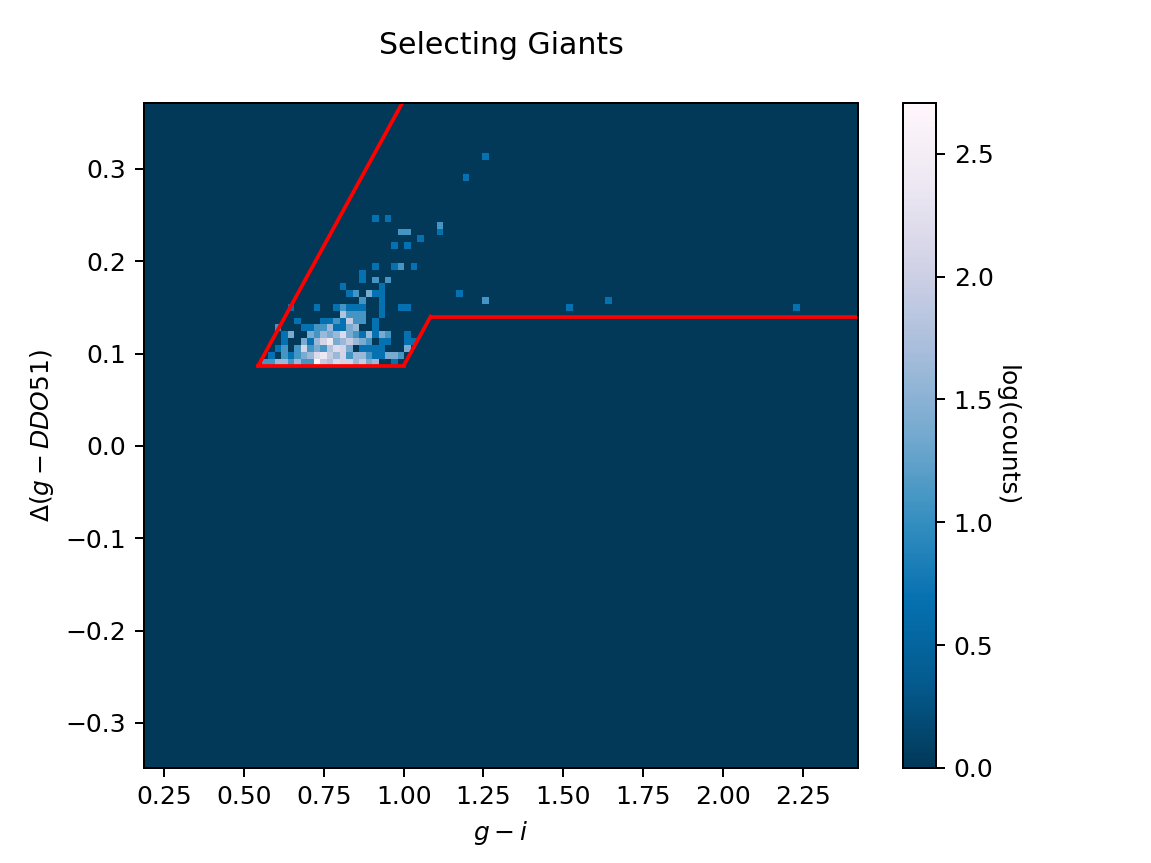

In [140]:
#Import modules
import matplotlib.pyplot as plt
%matplotlib nbagg

retm4[retm4==0]=1
ax = plt.imshow(np.log(retm4.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower',cmap='PuBu_r', aspect="auto")
plt.xlabel(r'$g-i$')
plt.ylabel(r'$\Delta (g-DDO51)$')
plt.title('Selecting Giants', y=1.05)
cbar = plt.colorbar()
cbar.set_label('log(counts)', rotation=270, labelpad=10)

#plt.scatter([0.62,1.13,1.20,1.71],[0.1,0.1,0.35,0.35],s=4,c='red')

plt.plot([0.544,1.12],[0.087,0.45],'k-',c='red')
plt.plot([0.544,1],[0.087,0.087],'k-',c='red')
plt.plot([1,1.0841],[0.087,0.14],'k-',c='red')
plt.plot([1.0841,2.7],[0.14,0.14],'k-',c='red')
plt.plot([1.12,2.7],[0.45,0.45],'k-',c='red')
plt.plot([2.7,2.7],[0.45,0.14],'k-',c='red')


plt.show()

In [ ]:
# Import modules
import numpy as np
from scipy import stats
import basic
from astropy.table import Table, vstack, hstack
from astropy.io import fits
import warnings
import pyfits

#Suppress iPython warnings
warnings.filterwarnings('ignore')

#Import list of exposures/CCDs
night = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\exposures.fits')

#Create blank array with 200*200 bins
retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0
retm4 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\retarray.npy')*0

#Load bin edges
xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\xedgegigd200b.npy')
yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\yedgegigd200b.npy')

#Make empty fits table
tab = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\2011\g11d302\pcat\g11d302.010.h5", path="1")
col1 = fits.Column(name='dr_g', format='D05', array=np.zeros(1))
col2 = fits.Column(name='dr_i', format='D05', array=np.zeros(1))
col3 = fits.Column(name='dr_z', format='D05', array=np.zeros(1))
col4 = fits.Column(name='dr_ddo51', format='D05', array=np.zeros(1))
col5 = fits.Column(name='tpm', format='D05', array=np.zeros(1))
coldefs = fits.ColDefs([col1, col2,col3,col4,col5])
dat = fits.BinTableHDU.from_columns(coldefs)
dat = Table.read(dat)
dat = dat[0:0]
tab = tab[0:0]
tab = hstack([dat,tab])
tab = np.array(tab)

#Write fits table to file
pyfits.writeto(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\Giants\giant_selection.fits', tab, clobber=True)

#Load all exposures
for i in range(0,43548):
    #Load data using basic.py
    chip = int(night['ccdn'][i])
    t = basic.Catalog.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), chips=chip)
    
    #Loading subscriptable catalog
    z = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), path="{0}".format(chip))
    
    #Load giants fits file
    tab = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\Giants\giant_selection.fits')
    
    #Correct for extinction
    g_extinct = t.extinction_correct('g')
    i_extinct = t.extinction_correct('i')
    d_extinct = t.extinction_correct('ddo51')

    ##########################
    ########  CUTS  ##########
    ##########################
    
    #Cuts
    ind, = np.where((z['e_ddo51']<0.3)&                    # Require okay errors
    (z['m_gaia']==2))                                      # Require a Gaia DR2 match
    
    #Applying match cuts
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Magnitude of less than 20 cut
    ind, = np.where(g_extinct<20)
    
    #Applying magnitude cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
    
    #Remove nans
    ind = np.where((~np.isnan(g_extinct))&(~np.isnan(i_extinct))&(~np.isnan(d_extinct)))
    
    #nan cut
    g_extinct = g_extinct[ind]
    i_extinct = i_extinct[ind]
    d_extinct = d_extinct[ind]
        
    ##########################
    
    #Numpy arrays with photometry
    g = np.array(g_extinct)
    i = np.array(i_extinct)
    d = np.array(d_extinct)
    
    #Colors
    y = g - d
    x = g - i
         
    ret,xed,yed,bin = stats.binned_statistic_2d(x,y,None,'count',bins=[xedge,yedge])
        
    retm3 = np.add(ret,retm3)

    #Removing last entry.  This will enable me to recenter the array values on the center of the bins.
    xe = xedge[0:200]
    ye = yedge[0:200]

    #Centering x and y values on center of bins
    xc = xe + (xedge[1] - xedge[0])/2
    yc = ye + (yedge[1] - yedge[0])/2

    count = retm3.T

    #Build up y values from maximum counts in each column
    ymaxcount = np.array([],dtype=int)
    for i in range(0,200):
        ycol = count[:,i]
        ymaxcount = np.append(ymaxcount,np.max(ycol))

    yidx = np.array([],dtype=int)

    for i in range(0,200):
        ycol = count[:,i]
        yt = np.where(count[:,i]==ymaxcount[i])
        yt = np.round(np.average(yt))
        yidx = np.array(np.append(yidx,yt),dtype=int)

    xcoord = xc
    ycoord = yc[yidx]

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    dloc = smooth(ycoord,12)
    #dloc = ycoord

    ind = np.where((xcoord>0)&(xcoord<2.5))
    dloc = dloc[ind]
    xcoord = xcoord[ind]

    #Adjusted dwarf locus
    photint = np.interp(x,xcoord,dloc)
    y = y  - photint
    
    ##########################
    ###### GIANT CUT #########
    ##########################
    
    ind, = np.where((y<0.6302*(x-0.544)+0.087)&
                    (y>0.087)&
                    (y<0.45)&
                    (x<2.7)&
                    ~((y<0.14)&(x>1.0841))&
                    ~((y<0.6302*(x-1)+0.087)&(x<1.0841)&(x>1)))
    x = x[ind]
    y = y[ind]
    
    ##########################

    #Apply cuts to fits table
    z = z[ind]
    
    #Append giants to fits table
    tab = vstack([tab,z])
    
    tab = np.array(tab)
    
    #Save giants fits to file
    pyfits.writeto(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\Giants\giant_selection.fits', tab, clobber=True)